In [20]:
import functools
import numpy as np

from complex_network.networks import network_factory
from complex_network.networks.network_spec import NetworkSpec
from complex_network.networks import pole_calculator

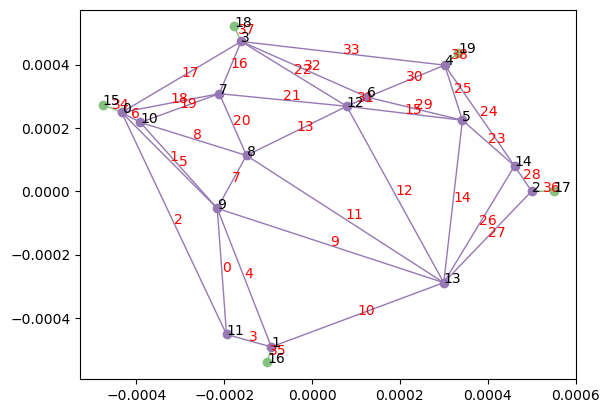

In [21]:
# Generate the random network
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=500e-6,
    external_size=550e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
network.draw(show_indices=True)
link_index = 9

In [22]:
# Check that refractive index derivative is working properly
n = network.get_link(link_index).n
dn = network.get_link(link_index).dn

dk0 = 0.1

lam0 = 500e-9
k0 = 2 * np.pi / lam0
k1 = k0 + dk0

n0 = n(k0)
n1 = n(k1)

dndk = (n1 - n0) / dk0
theory = dn(k0)

print(f"Calculated: {dndk}")
print(f"Theory: {theory}")
print(f"Difference: {np.abs(theory - dndk)}")

Calculated: 2.645519359134596e-09
Theory: 2.6455192676105925e-09
Difference: 9.152400354495752e-17


In [23]:
# Calculate the product S^dag S in three different ways
# REAL WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0

# 1) Formula
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula

# 2) Volume
U_0 = network.get_U_0(k0)
prod_volume = np.identity(len(U_0), dtype=np.complex128) - U_0


# Compare
print(f"Formula vs Volume: {np.max(np.abs(prod_formula - prod_volume))}")

Formula vs Volume: 4.107825191113079e-15


In [24]:
print(prod_volume)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [25]:
# Calculate the product S^dag S in three different ways
# COMPLEX WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()

# 1) Formula
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula

# 2) Volume
U_0 = network.get_U_0(k0)
prod_volume = np.identity(len(U_0), dtype=np.complex128) - U_0


# Compare
print(f"Formula vs Volume: {np.max(np.abs(prod_formula - prod_volume))}")

Formula vs Volume: 9.68015433429065e-16


In [26]:
# Calculate k0 Wigner Smith operator directly and using volume integrals
# REAL WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0

ws_direct = network.get_wigner_smith(k0)
ws_volume = network.get_wigner_smith_volume(k0)

# Compare
print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(
    f"Ratio: {np.max(np.abs(ws_volume - ws_direct)) / np.min(np.abs(ws_direct))}"
)

Difference: 2.949747308632821e-17
Smallest value: 0.0005261267328235569
Ratio: 5.6065337961491794e-14


In [27]:
# Calculate k0 Wigner Smith operator directly and using volume integrals
# COMPLEX WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()

ws_direct = network.get_wigner_smith(k0)
ws_volume = network.get_wigner_smith_volume(k0)

# Compare
print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(
    f"Ratio: {np.max(np.abs(ws_volume - ws_direct)) / np.min(np.abs(ws_direct))}"
)

Difference: 5.062955289862377e-16
Smallest value: 0.0005251812723845745
Ratio: 9.640395718747042e-13


In [28]:
# Calculate perurbation Wigner Smith operator directly and using volume integrals
# REAL WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0

ws_direct = network.get_wigner_smith(k0, "Dn", perturbed_link_index=link_index)
ws_volume = network.get_wigner_smith_volume(
    k0, "Dn", perturbed_link_index=link_index
)

# Compare
diff = ws_direct - ws_volume

print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(
    f"Ratio: {np.max(np.abs(ws_volume - ws_direct)) / np.min(np.abs(ws_direct))}"
)

Difference: 1.4079278354379191e-11
Smallest value: 250.8866203625754
Ratio: 5.611809164646625e-14


In [29]:
# Calculate alpha Wigner Smith operator directly and using volume integrals
# COMPLEX WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()

ws_direct = network.get_wigner_smith(k0, "Dn", perturbed_link_index=link_index)
ws_volume = network.get_wigner_smith_volume(
    k0, "Dn", perturbed_link_index=link_index
)

# Compare
diff = ws_direct - ws_volume

print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(f"Smallest value: {np.min(np.abs(ws_direct))}")
print(
    f"Ratio: {np.max(np.abs(ws_volume - ws_direct)) / np.min(np.abs(ws_direct))}"
)

Difference: 1.2728033999849067e-08
Smallest value: 247.21443899993594
Ratio: 5.148580338324156e-11


In [30]:
# Calculate trace of residue of k0 Wigner Smith operator directly and
# using volume integrals at the pole
pole = 12532230.332102112 - 11.136143180724291j

# 1) Direct
res_direct = pole_calculator.get_residue(network.get_wigner_smith, pole)
trace_direct = np.trace(res_direct)

res_volume = pole_calculator.get_residue(network.get_wigner_smith_volume, pole)
trace_volume = np.trace(res_volume)

# Compare
print(f"Difference: {np.max(np.abs(trace_volume - trace_direct))}")
print(f"Smallest value: {np.min(np.abs(trace_direct))}")
print(
    f"Ratio: {np.max(np.abs(trace_volume - trace_direct)) / np.min(np.abs(trace_direct))}"
)

Difference: 1.0774165449231084e-12
Smallest value: 1.0107504852593063
Ratio: 1.0659569900148988e-12


In [31]:
# Calculate Wigner Smith operator directly and using volume integrals
# POLE
k0 = 12532230.332102112 - 11.136143180724291j

# Define functions to calculate residues for
direct = functools.partial(
    network.get_wigner_smith, variable="Dn", perturbed_link_index=link_index
)
volume = functools.partial(
    network.get_wigner_smith_volume,
    variable="Dn",
    perturbed_link_index=link_index,
)

res_direct = pole_calculator.get_residue(direct, pole)
trace_direct = np.trace(res_direct)

res_volume = pole_calculator.get_residue(volume, pole)
trace_volume = np.trace(res_volume)

# Compare
print(f"Difference: {np.max(np.abs(trace_volume - trace_direct))}")
print(f"Smallest value: {np.min(np.abs(trace_direct))}")
print(
    f"Ratio: {np.max(np.abs(trace_volume - trace_direct)) / np.min(np.abs(trace_direct))}"
)

Difference: 9.018084805045823e-08
Smallest value: 78107.49334786863
Ratio: 1.154573577836102e-12


In [32]:
# Compare ratio of traces to ratio of residues with direct method
pole = 12532230.332102112 - 11.136143180724291j

# Matrices
ws_direct_k0 = network.get_wigner_smith(pole)
ws_direct_Dn = network.get_wigner_smith(
    pole, "Dn", perturbed_link_index=link_index
)
trace_direct_k0 = np.trace(ws_direct_k0)
trace_direct_Dn = np.trace(ws_direct_Dn)
ratio_direct = trace_direct_k0 / trace_direct_Dn

# Residues
res_direct_k0 = pole_calculator.get_residue(network.get_wigner_smith, pole)
res_trace_direct_k0 = np.trace(res_direct_k0)

direct = functools.partial(
    network.get_wigner_smith, variable="Dn", perturbed_link_index=link_index
)
res_direct_Dn = pole_calculator.get_residue(direct, pole)
res_trace_direct_Dn = np.trace(res_direct_Dn)
ratio_res_direct = res_trace_direct_k0 / res_trace_direct_Dn

# Compare
print(f"Difference: {np.max(np.abs(ratio_direct - ratio_res_direct))}")
print(f"Smallest value: {np.min(np.abs(ratio_direct))}")
print(
    f"Ratio: {np.max(np.abs(ratio_direct - ratio_res_direct)) / np.min(np.abs(ratio_direct))}"
)

Difference: 5.987658829735442e-12
Smallest value: 1.2940511307409686e-05
Ratio: 4.6270651039166685e-07


In [33]:
# Compare ratio of traces to ratio of residues with volume method
pole = 12532230.332102112 - 11.136143180724291j

# Matrices
ws_volume_k0 = network.get_wigner_smith_volume(pole)
ws_volume_Dn = network.get_wigner_smith_volume(
    pole, "Dn", perturbed_link_index=link_index
)
trace_volume_k0 = np.trace(ws_volume_k0)
trace_volume_Dn = np.trace(ws_volume_Dn)
ratio_volume = trace_volume_k0 / trace_volume_Dn

# Residues
res_volume_k0 = pole_calculator.get_residue(
    network.get_wigner_smith_volume, pole
)
res_trace_volume_k0 = np.trace(res_volume_k0)

volume = functools.partial(
    network.get_wigner_smith_volume,
    variable="Dn",
    perturbed_link_index=link_index,
)
res_volume_Dn = pole_calculator.get_residue(volume, pole)
res_trace_volume_Dn = np.trace(res_volume_Dn)
ratio_res_volume = res_trace_volume_k0 / res_trace_volume_Dn

# Compare
print(f"Difference: {np.max(np.abs(ratio_volume - ratio_res_volume))}")
print(f"Smallest value: {np.min(np.abs(ratio_volume))}")
print(
    f"Ratio: {np.max(np.abs(ratio_volume - ratio_res_volume)) / np.min(np.abs(ratio_volume))}"
)

Difference: 1.1845342527482e-05
Smallest value: 3.1041694829988635e-06
Ratio: 3.815945808486752


In [34]:
# NOTE: ratio_volume doesn't work, which was the issue before we went down
# the whole residue rabbit hole. But that's okay, because ratio_res_volume
# does work, which is all that really matters ultimately.

print(ratio_direct)
print(ratio_res_direct)
print(ratio_volume)
print(ratio_res_volume)

(1.0521712221724627e-05-7.533286455485981e-06j)
(1.0521709493919398e-05-7.533281125276145e-06j)
(2.762084979901352e-06+1.4165997116280877e-06j)
(1.0521709493920527e-05-7.533281125277305e-06j)


In [35]:
# Can I just use 1j for the ws_k0 trace residue?
ratio_direct_j = 1j / res_trace_direct_Dn
print(ratio_direct_j)

(1.0409799030282685e-05-7.453156181029873e-06j)


In [36]:
# Check res of k0 vs 1j
# Compare ratio of traces to ratio of residues with direct method
pole = 12532230.332102112 - 11.136143180724291j

# Residues
one = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole))
two = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole, degree=100))
three = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole, degree=1000))
four = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole, radius=0.1))
five = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole, radius=1))
six = np.trace(pole_calculator.get_residue(network.get_wigner_smith, pole, radius=1, degree=1000))

print(one)
print(two)
print(three)
print(four)
print(five)
print(six)

(-9.742089922964992e-09+1.0107504852593063j)
(-9.705729026032728e-09+1.0107503195120766j)
(-9.693946031313905e-09+1.010750320773679j)
(-9.742089922964992e-09+1.0107504852593063j)
(-1.9011767379353839e-06+1.010727825612431j)
(-1.9051874866511664e-06+1.0107276691588112j)
